## Model generator main file

In [1]:
import numpy as np
import re
import unidecode
import os
import pickle
import sys

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection     import GridSearchCV

import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints           import maxnorm
from keras                       import regularizers
from keras                       import Input, Model, Sequential
from keras.layers                import TimeDistributed, CuDNNLSTM, Bidirectional, Activation, TimeDistributed, Dense, RepeatVector, Embedding, Dropout, BatchNormalization
from keras.layers.recurrent      import LSTM, GRU, SimpleRNN
from keras.utils                 import np_utils
from keras.callbacks             import EarlyStopping, TensorBoard, ModelCheckpoint

Using TensorFlow backend.


Import data and make folders

In [14]:
data_path = 'data'
temp_path = data_path + '/temp'
backup_path = data_path + '/backup'
weights_path = data_path + '/weights'
train_history = data_path + '/train_history'

if not os.path.isdir(data_path):
    os.mkdir(data_path)
if not os.path.isdir(temp_path):
    os.mkdir(temp_path)
if not os.path.isdir(backup_path):
    os.mkdir(backup_path)
if not os.path.isdir(weights_path):
    os.mkdir(weights_path)
if not os.path.isdir(train_history):
    os.mkdir(train_history)

#joint_angle_data.pickle
with open(data_path + '/augmented_input.pickle', 'rb') as file:
    joint_angle_data = pickle.load(file)
    file.close()

#power_data.pickle
with open(data_path + '/power_data.pickle', 'rb') as file:
    power_data = pickle.load(file)
    file.close()
    
print('===== Check sizes =====')
print('joint_angle_data shape is: ')
print(joint_angle_data.shape)
print('power_data shape is: ')
print(power_data.shape)
print('First value needs to be equal!')

===== Check sizes =====
joint_angle_data shape is: 
(32501, 19)
power_data shape is: 
(32501, 1)
First value needs to be equal!


## Recurrent neural networks

Different model functions

In [64]:
def mean_square_error(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred))

In [65]:
def setModelToBasicLSTM(self, multiple=False):
    n_timesteps, n_features, n_outputs = self.X_train.shape[1], self.X_train.shape[2], self.Y_train.shape[1]
    # define model
    self.model = Sequential()
    self.model.add(Bidirectional(CuDNNLSTM(256, return_sequences = True, kernel_initializer = 'random_uniform', bias_initializer = 'zero', input_shape = (n_timesteps, n_features))))
    self.model.add(Dropout(0.2))
    self.model.add(Bidirectional(CuDNNLSTM(256, return_sequences = True, kernel_initializer = 'random_uniform', bias_initializer = 'zero')))
    self.model.add(Dropout(0.2))
    self.model.add(Bidirectional(CuDNNLSTM(256, return_sequences = True, kernel_initializer = 'random_uniform', bias_initializer = 'zero')))
    self.model.add(Dropout(0.2))
    self.model.add(Bidirectional(CuDNNLSTM(256, return_sequences = multiple, kernel_initializer = 'random_uniform', bias_initializer = 'zero')))
    self.model.add(Dropout(0.2))
    if multiple:
        self.model.add(TimeDistributed(Dense(256, activation='relu', kernel_initializer = 'random_uniform', bias_initializer = 'zero')))
        self.model.add(TimeDistributed(Dense(n_outputs)))
    else:
        self.model.add(Dense(256, activation='relu', kernel_initializer = 'random_uniform', bias_initializer = 'zero'))
        self.model.add(Dense(n_outputs))
    self.model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_square_error])


In [66]:
def setModelToGridSearch(self, multiple=False, layer_type=CuDNNLSTM, hidden_units_RNN=128, hidden_units_dense=64, num_mid_layers = 3, optimizer='adam', learn_rate=0.01, momentum=0, init_mode='random_uniform', activation='relu', dropout_rate=0.0, weight_constraint=0, num_dense_layers=1):
    n_timesteps, n_features, n_outputs = self.X_train.shape[1], self.X_train.shape[2], self.Y_train.shape[1]
    # define model
    self.model = Sequential()
    self.model.add(Bidirectional(layer_type(hidden_units_RNN, return_sequences = True, kernel_initializer = init_mode, bias_initializer = 'zero', input_shape = (n_timesteps, n_features))))
    for n in range(num_mid_layers):
        self.model.add(Bidirectional(layer_type(hidden_units_RNN, return_sequences = True, kernel_initializer = init_mode, bias_initializer = 'zero')))
        self.model.add(Dropout(dropout_rate))
        
    self.model.add(Bidirectional(layer_type(hidden_units_RNN, return_sequences = multiple, kernel_initializer = init_mode, bias_initializer = 'zero')))
    self.model.add(Dropout(dropout_rate))
    
    if multiple:
        for n in range(num_dense_layers):
            self.model.add(Dense(hidden_units_dense, activation=activation, kernel_initializer = 'random_uniform', bias_initializer = 'zero')) #, kernel_constraint=maxnorm(weight_constraint)
    
        self.model.add(Dense(n_outputs))
    else:
        for n in range(num_dense_layers):
            self.model.add(TimeDistributed(Dense(hidden_units_dense, activation=activation, kernel_initializer = 'random_uniform', bias_initializer = 'zero'))) #, kernel_constraint=maxnorm(weight_constraint)
    
        self.model.add(TimeDistributed(Dense(n_outputs)))
        
    self.model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=["accuracy"])
    return self.model

Other functions

In [67]:
def series_to_supervised(dataX, dataY, n_input, n_output):
    #Output: [batchs, n_timesteps, n_features]
    df_X = pd.DataFrame(dataX)
    df_Y = pd.DataFrame(dataY)
    X = np.ndarray((df_X.shape[0]-n_input, n_input, df_X.shape[1]) )
    Y = np.ndarray((df_Y.shape[0]-n_input, n_output))

    for n in range(0,df_X.shape[0]-n_input-1,1):
        for m in range(n_input-1,-1, -1):
            X[n,m,:] = df_X.loc[n+m:n+m,:]
            
    for n in range(0,df_Y.shape[0]-n_input-1,1):
        for m in range(n_output-1,-1, -1):
            Y[n,:] = df_Y.loc[n+m:n+m,:]
            
    return X, Y

In [68]:
def setUpData(self, seq_length, dataX, dataY, n_test_ratio):

    self.X_train = []
    self.Y_train = []
    self.X_test = []
    self.Y_test = []
    self.seq_length = seq_length
    
    X, Y = series_to_supervised(dataX, dataY, n_input=seq_length, n_output=dataY.shape[1])
    
    self.X_train = X[:int(len(X)*(1-n_test_ratio)), :, :]
    self.Y_train = Y[:int(len(Y)*(1-n_test_ratio)), :]
    self.X_test = X[int(len(X)*(1-n_test_ratio)):, :, :]
    self.Y_test = Y[int(len(Y)*(1-n_test_ratio)):, :]
    

In [69]:
def trainModel(self, name):
    # File path for model
    filepath = weights_path + "/weights-" + name + "-{epoch:02d}-{loss:.4f}.hdf5"
    # Callbacks functions
    es = EarlyStopping(monitor='val_loss', patience=40, verbose=0)
    tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32)
    mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
    
    # Train the model
    epochs = 40           #Maximum number of epochs to run
    batch_size = 16    #Size of training data batch
    Val_split = 0.1       #Procentage of training data to use as validation data
    history = self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size, validation_split=Val_split, callbacks=[es, tb, mc])
    
    # Save the model
    filename = "model_" + name + ".hdf5"
    self.model.save_weights(weights_path + '/' + filename)
    # Save the history
    filename = "history_" + name + ".pickle"
    with open(train_history + '/' + filename, 'wb') as f:
        pickle.dump(history.history, f)
        f.close()

Model generator

In [70]:
class Generator:

    set_up_data = setUpData
    train_model = trainModel
    
    set_model_to_Basic_LSTM = setModelToBasicLSTM
    set_model_to_Grid_Search = setModelToGridSearch
    

## Training the network

Test training

In [71]:
gen = Generator()
seqLleng = 10 #12ms/leng unit
n_test_ratio = 0.02
print((power_data.shape))
gen.set_up_data(seqLleng, joint_angle_data, power_data, n_test_ratio)
print(gen.X_train.shape)
print(gen.Y_train.shape)
print(gen.X_test.shape)
print(gen.Y_test.shape)
gen.set_model_to_Basic_LSTM(multiple=False)
name = 'test_run'
gen.train_model(name = name)

(32501, 1)
(31841, 10, 19)
(31841, 1)
(650, 10, 19)
(650, 1)
Train on 28656 samples, validate on 3185 samples
Epoch 1/40
28656/28656 [==============================] - 48s 2ms/step - loss: 4678614.5010 - mean_square_error: 4678614.5010 - val_loss: 3088889.2062 - val_mean_square_error: 3088889.20625 - mean_square_error: 4
Epoch 2/40
28656/28656 [==============================] - 47s 2ms/step - loss: 4120147.8192 - mean_square_error: 4120147.8192 - val_loss: 3308651.6131 - val_mean_square_error: 3308651.6131
Epoch 3/40
28656/28656 [==============================] - 48s 2ms/step - loss: 4123805.6009 - mean_square_error: 4123805.6009 - val_loss: 3344440.2013 - val_mean_square_error: 3344440.2013
Epoch 4/40
28656/28656 [==============================] - 47s 2ms/step - loss: 4124297.0091 - mean_square_error: 4124297.0091 - val_loss: 3194713.9274 - val_mean_square_error: 3194713.9274
Epoch 5/40
28656/28656 [==============================] - 46s 2ms/step - loss: 4121944.1135 - mean_square_erro

Hyperparamter Grid Search

In [49]:
gen_gs = Generator()
# Variables
seqLleng = 10 #12ms/leng unit
n_test_ratio = 0.02
# Set up the data
print('Setting up data')
gen_gs.set_up_data(seqLleng, joint_angle_data, power_data, n_test_ratio)
# create model
print('Creating keras Classifier')
model = KerasClassifier(build_fn=gen_gs.set_model_to_Grid_Search, epochs=1, batch_size=16, verbose=1)
# define the grid search parameters
multiple = [False]
layer_type = [CuDNNLSTM]
hidden_units_RNN = [32, 64, 128]
hidden_units_dense = [64]
num_dense_layers = [1]
num_mid_layers = [1]
optimizer = ['adam']
learn_rate = [0.01]
momentum = [0]
init_mode = ['random_uniform']
activation = ['relu']
dropout_rate = [0.0]
weight_constraint = [0]
# Make dictionary
param_grid = dict(multiple=multiple,
                  layer_type=layer_type,
                  hidden_units_dense=hidden_units_dense,
                  hidden_units_RNN=hidden_units_RNN,
                  num_mid_layers=num_mid_layers,
                  optimizer=optimizer,
                  init_mode=init_mode,
                  activation=activation,
                  dropout_rate=dropout_rate
                  num_dense_layers=num_dense_layers)
# Grid Search
print('Grid Search Starting')
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
print('X: ' + str(gen_gs.X_train.shape))
print('Y: ' + str(gen_gs.Y_train.shape))
grid_result = grid.fit(gen_gs.X_train, gen_gs.Y_train)


Setting up data
Creating keras Classifier
Grid Search Starting
X: (31841, 10, 19)
Y: (31841, 1)
Epoch 1/1
21227/21227 [==============================] - 6s 305us/step
Epoch 1/1
21227/21227 [==============================] - 6s 301us/step
Epoch 1/1
21228/21228 [==============================] - 6s 301us/step
Epoch 1/1
21227/21227 [==============================] - 7s 308us/step
Epoch 1/1
21227/21227 [==============================] - 7s 332us/step
Epoch 1/1
21228/21228 [==============================] - 7s 313us/step
Epoch 1/1
21227/21227 [==============================] - 7s 334us/step
Epoch 1/1
21227/21227 [==============================] - 7s 328us/step
Epoch 1/1
21228/21228 [==============================] - 7s 330us/step
Epoch 1/1
31841/31841 [==============================] - 33s 1ms/step - loss: 4957858.1132 - acc: 1.8844e-04


## Test prediction

In [72]:
predictions_train = gen.model.predict(gen.X_train)
predictions_test = gen.model.predict(gen.X_test)

Plot the test prediction

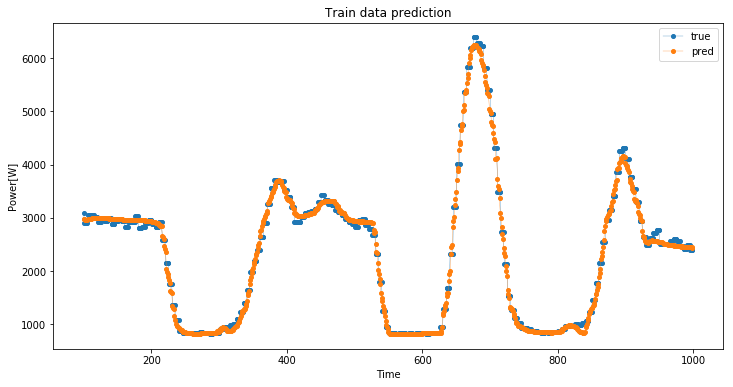

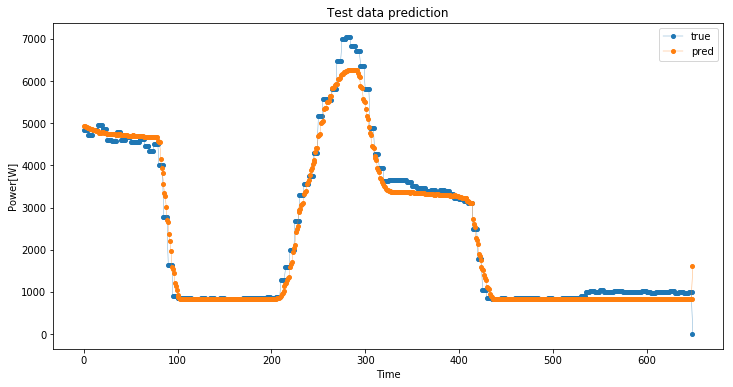

In [76]:
plt.figure(figsize=(12,6))
fig1 = plt.subplot()
x1 = range(len(predictions_train))
fig1.plot(x1[100:1000], gen.Y_train[100:1000],  label='true',  marker='o',linewidth=0.3, markersize=4)
fig1.plot(x1[100:1000], predictions_train[100:1000],  label='pred',  marker='o',linewidth=0.3, markersize=4)
fig1.legend();
fig1.set_ylabel('Power[W]')
fig1.set_xlabel('Time')
fig1.set_title('Train data prediction');

plt.figure(figsize=(12,6))
fig2 = plt.subplot()
x2 = range(len(predictions_test))
fig2.plot(x2, gen.Y_test,  label='true',  marker='o',linewidth=0.3, markersize=4)
fig2.plot(x2, predictions_test,  label='pred',  marker='o',linewidth=0.3, markersize=4)
fig2.legend();
fig2.set_ylabel('Power[W]')
fig2.set_xlabel('Time')
fig2.set_title('Test data prediction');